# 🔥 Introduction to coding Neural Networks with PyTorch




We need a lot more imported libraries in this notebook, as we are going to be
- reading in data from a file
- and also implimenting some higher level machine learning techniques

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### 🤞 Download the data
Lets first try and download the planetary data that we need from where they are stored on google drive. Notice that the file is in a weird format (`.hdf5`) and you probably can't open it normally just by clicking on it.

In [ ]:
! gdown https://drive.google.com/uc?id=1gl5W5PexON0wBfajUTPEkd9AiEnHo4rL -O data.hdf5

zsh:1: no matches found: https://drive.google.com/uc?id=1gl5W5PexON0wBfajUTPEkd9AiEnHo4rL


# 🌌 What is an HDF5 File?

HDF5 (Hierarchical Data Format v5) is a powerful file format designed to store and organize large amounts of data efficiently. For astrophysics, this is especially useful because it can handle **complex, multi-dimensional datasets** (like simulations or observations 🌠) while maintaining high performance in reading and writing data.

### Key Features:
- **Hierarchical Structure**: Think of it as a file-system-within-a-file 🗂️. You can organize data into groups and datasets for easy access.
- **Efficient Storage**: Supports compression and chunking, ideal for managing massive datasets from telescopes or simulations 🛰️.
- **Metadata Support**: Attach descriptive information to your data for better context and usability 🏷️.

HDF5 files are widely used in astrophysics for handling datasets like cosmic microwave background maps, galaxy catalogs, particle simulations, or in this case, exoplanet observations. 🚀✨

If we open the file in python using the xarray package, then we can see that it contains 22 seperate folders, each with data in. The file gives us some information about this data at the top as well, most importantly the dimensions. We are specifically interested in the wavelength, as this will be where the raw spectra data are stored. Samples will tell us how many examples of spectra that we have, which should be around 70,000 🪐


In [ ]:
# open hdf5
path ="data.hdf5"

ds = xr.open_dataset(path)
ds

<xarray.Dataset> Size: 329MB
Dimensions:                 (wavelength: 52, sample: 91392, parameter: 6,
                             quartile: 3, species: 5)
Coordinates:
  * wavelength              (wavelength) float64 416B 0.55 0.7 ... 6.814 7.276
  * sample                  (sample) int64 731kB 0 1 2 3 ... 91389 91390 91391
  * parameter               (parameter) <U13 312B 'planet_temp_k' ... 'log_NH3'
  * quartile                (quartile) <U2 24B 'q1' 'q2' 'q3'
  * species                 (species) <U3 60B 'H2O' 'CO2' 'CH4' 'CO' 'NH3'
Data variables: (12/22)
    bin_width               (wavelength) float64 416B ...
    spectrum                (sample, wavelength) float64 38MB ...
    noise                   (sample, wavelength) float64 38MB ...
    planet_temp_k           (sample) float64 731kB ...
    log_H2O                 (sample) float64 731kB ...
    log_CO2                 (sample) float64 731kB ...
    ...                      ...
    planet_radius_m         (sample) float64 731kB ...
    planet_surface_gravity  (sample) float64 731kB ...
    valid_quartiles         (sample) bool 91kB ...
    parameter_quartiles     (sample, parameter, quartile) float64 13MB ...
    contributions           (sample, species, wavelength) float64 190MB ...
    clean_forward_model     (sample, wavelength) float64 38MB ...

### 👀 Let's visualise some of this data
The below code will extract the first (`i=0`) planet from the data and plot the spectra.

######################################################################
 Aundance of log_H2O in planetary atmosphere for planet 0 is -6.4848
######################################################################


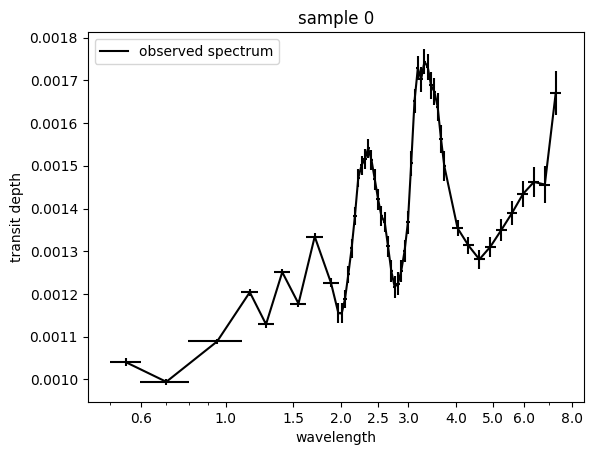

In [ ]:
i = 0

# plt.plot(ds['wavelength'],ds['contributions'].sel(sample=i,species=['H2O']).values.T, label='H2O')

plt.plot(ds['wavelength'],ds['spectrum'].sel(sample=i).values, "k-", label='observed spectrum')

plt.errorbar(ds['wavelength'],ds['spectrum'].sel(sample=i).values,xerr=ds['bin_width']/2, yerr=ds['noise'].sel(sample=i).values, fmt='none', color='black', )


plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.title(f'sample {i}')
plt.legend()


# print the species present in the sample
s_ = 'log_H2O'
print("#"*70)
print(f" Aundance of {s_} in planetary atmosphere for planet {i} is {ds[s_].sel(sample=i).values:.4f}")
print("#"*70)

## 🚀 Convert HDF5 Files to NumPy Arrays

While HDF5 files are excellent for **storing and organizing large datasets**, working with them directly in Python can be less efficient for certain tasks, especially in **machine learning** workflows with frameworks like PyTorch. Here's why converting HDF5 data to **NumPy arrays** is a great idea:

### ⚡ Speed and Performance
- NumPy arrays are highly optimized for numerical computations and are faster to manipulate in Python 🏎️.
- Machine learning ibraries like PyTorch which we will be using natively support NumPy arrays, allowing for seamless conversion to tensors and faster data loading 🔄.

### 📚 Simplicity
- NumPy arrays are easier to slice, index, and manipulate compared to hierarchical structures in HDF5 files 🧩.
- Simplifies data preprocessing and transformation pipelines for machine learning.
- We can also get rid of a lot of the unnessecary data in the HDF5 file that we are not interested in this time around


In [ ]:
label_names = ['log_H2O']
labels = ds[label_names]
labels_np = labels.to_array().values.T

labels_np.shape

(91392, 1)

In [ ]:
spectra_np = ds['spectrum'].values
spectra_np.shape

(91392, 52)

# 🧠 Creating the Neural Network Model

This is where we will define the architecture of the model that we are going to train

### 🚀 Model Structure

`self.fc1 = nn.Linear(a, b)` creates a layer with `a` input features and `b` output features.

So, `self.fc1 = nn.Linear(52, 512)` creates a layer with 52 input features and 512 output features.

The number of input features for the first layer _must match the size of the data_ and similarly the size of the output of the last layer _must match the number of things you are trying to predict_, which in this case is only 1

### 🧘‍♀️ Flexibility
You can easily add more layers or modify the architecture to improve the model performance for specific use cases.


In [ ]:
class model_A(nn.Module):
    def __init__(self):
        super(model_A, self).__init__()

        self.fc1 = nn.Linear(52, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## ✍️ Student Task: Try different models
Have a go training model A, B and C, and see which one you think has the better performance. If you are feeling up to it, create a model of your own and try training that as well. See if you can beat the loss performance of the models I have given you here.

In [ ]:
class model_B(nn.Module):
    def __init__(self):
        super(model_B, self).__init__()

        self.fc1 = nn.Linear(52, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
class model_C(nn.Module):
    def __init__(self):
        super(model_C, self).__init__()

        self.fc1 = nn.Linear(52, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class model_D(nn.Module):
    def __init__(self):
        super(model_D, self).__init__()

        self.fc1 = nn.Linear( # Your code here...


    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu( # Your code here...

        return x

SyntaxError: invalid syntax (15345530.py, line 8)

### 🔀 Change the model used here!

Modify the line below to change which model is being used to train

In [ ]:
model = # Modify this to select the model of your choice!

This is where we define the loss function, which is evaluating how good your model is at predicting the amount of water in the planet atmosphere.

In [ ]:
# create a loss function
criterion = nn.MSELoss()

## 📈 Understanding The Optimiser and _Learning Rate_

The **learning rate** (often denoted as `lr`) is a critical hyperparameter in machine learning algorithms. It determines the amount of change that is made to the model weights each epoch to get closer to the solution.

### How It Works
- During training, the model updates its parameters (weights) to reduce the error by following the loss function.
- The learning rate controls how much the parameters are adjusted in each update 🛠️.

### Choosing the Right Learning Rate
- **Too High**: The model may overshoot the optimal solution, causing the loss to oscillate or even diverge 🚀❌.
- **Too Low**: The training process will be very slow and might get stuck in local minima, which is where the model can't keep taking smaller steps to get to a better solution, but needs to try something radically different to keep exploring.
- **Just Right**: A properly tuned learning rate helps the model converge efficiently onto the solution 🎯.

The learning rate is a key factor in determining the speed and success of your training process. A good choice can make the difference between a well-trained model and one that fails to converge! 🏆✨


here we assign the optimiser, which controls the learning rate.

### ✍️ Student Task: Learning rate exploration
Modify the learning rate to see the effect that this has on model training.

In [ ]:
lr = 0.0005

optimizer = optim.Adam(model.parameters(), lr=lr)

# 🗂️ Understanding Batch Size in Machine Learning

**Batch size** is an important hyperparameter in machine learning that defines the number of **training examples** processed together before the model updates its parameters.

### How It Works
- During training, data is divided into smaller subsets called **batches**.
- Each batch is used to calculate the **loss** and perform a single **gradient update**.

### Types of Batch Sizes
1. **Small Batch (Mini-batch)**:
   - Size: Usually between 32 and 512.
   - **Pros**: Faster updates, better generalization 🏃.
   - **Cons**: More noise in gradients 🚧.
2. **Large Batch**:
   - Size: Can be thousands of examples.
   - **Pros**: More stable gradients, efficient training on larger machines 💻.
   - **Cons**: Higher memory usage, and can potentially cause overfitting, where the model has been optimised for only a certain subset of the true data, meaning it will likely perform badly on examples that are not present within the training dataset 📈.
3. **Full Batch**:
   - All data is processed at once.
   - Rarely used due to memory and speed limitations 🐢.

### Choosing the Right Batch Size
- **Small Batch Sizes**: Often better for noisy datasets and limited hardware resources 🎯.
- **Larger Batch Sizes**: Useful for smooth convergence when sufficient computational power is available 💪.

### Impact on Training
- Smaller batches add **stochasticity** to training, which is like adding noise and randomness. It helps models generalize better, because within each batch the model is training to a small subset of the data, which is likely not representative of the full distribution. This means that the model needs to learn to cope better with data which is outside of the subset of data which it was trained on.
- Larger batches make training more deterministic, which can lead to faster convergence but may reduce generalization.

The choice of batch size is a balance between **training speed, memory constraints, and model performance**. It’s often best to experiment with different sizes to find the optimal value for your task! 🏆✨


here we assign the data loader, which controls the batch size.

### ✍️ Student Task: Batch size exploration
Modify the batch size to see the effect that this has on model training.

In [ ]:
batch_size = 1000

train_dataset = TensorDataset(torch.Tensor(spectra_np), torch.Tensor(labels_np))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## 📈 Training Begins!

Here we will start to train the model over a small number of epochs. Notice how the loss decreases (hopefully!) per epoch. This means the model is learning

In [ ]:
batch_losses = []
epoch_losses = []


# train the model
model.train()
for epoch in range(6):

    for i, data in enumerate(train_loader):

        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())


    epoch_losses.append(np.mean(batch_losses))
    batch_losses = []

    print(f'epoch {epoch}, loss {epoch_losses[-1]}')

## 👀 Visualising the training process

Lets visualise this like we were doing in class. by creating some functions which plot the data.

In [ ]:
def plot_loss(losses, epoch):

    losses = np.array(losses)

    plt.figure()
    plt.plot(losses, "k-")

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'training loss\nepoch: {epoch}')

    plt.yscale('log')

    plt.ylim(losses.mean() - 3 * losses.std(), 4)

    plt.savefig('training_loss.png')
    plt.close()

In [ ]:
def plot_predictions(predictions, labels, epoch):
    # make sure plot is square
    plt.figure(figsize=(5, 5))
    plt.plot(labels, predictions, "k.", label='predictions')
    plt.plot(labels, labels, "r--", label='Ground Truth')
    plt.xlabel('true log H2O value')
    plt.ylabel('predicted H2O value')
    plt.title(f'predictions\nepoch: {epoch}')

    plt.xlim(labels.min(), labels.max())
    plt.ylim(labels.min(), labels.max())

    plt.savefig('predictions.png')
    plt.close()

## 🚴‍♀️ Training for real

Lets run a lot more epochs of training, with this new visualisation.

_Hint: If the loss looks like it is still decreasing after the 50 epochs I have used here, then up this number, with the caviat of course that more epochs of training will take longer to run. We can speed up the training in a minute by using a GPU_

The model should save 2 image files, which are updated as the training goes on, which you can see in the left hand bar under the folder icon 📁. One will show the batch prediction against the truth, and the other will show the loss history 🕰️.

In [ ]:
batch_losses = []
epoch_losses = []


# train the model
model.train()
for epoch in range(50):

    for i, data in enumerate(train_loader):

        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())


    epoch_losses.append(np.mean(batch_losses))
    batch_losses = []


    if epoch % 5 == 0: # this code only executes every 5 epochs
        plot_loss(epoch_losses, epoch)
        plot_predictions(outputs.detach().numpy(), labels.detach().numpy(), epoch)

    if epoch % 20 == 0: # this code only executes every 20 epochs
        print(f'epoch {epoch}, loss {epoch_losses[-1]}')

# 🚨 If you are working through this at home **stop here**
## We will cover this next session in class

---
### ✍️ Student Task: Lets put these models to the test.

We will now test our best model against some planets that it has not seen before in training! As we train the model, we will calculate the model performance on the seen (train) data, and also on unseen (test) data. This helps us to get a better understanding of the model capabilities.

We need to define a new loss plotting function for testing our competition models as we have an extra dataset to consider

In [ ]:
def plot_loss(losses, test_losses, epoch):

    losses = np.array(losses)
    test_losses = np.array(test_losses)

    plt.figure()
    plt.plot(losses, "k-", label='train loss')
    plt.plot(test_losses, "g-", label='test loss')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'training loss\nepoch: {epoch}')

    plt.yscale('log')
    plt.legend()

    plt.ylim(test_losses.mean() - 3 * test_losses.std(), 4)

    plt.savefig('training_loss.png')
    plt.close()


### 🏁 Competition Time! 🏁

In [ ]:
# split train into train and test - we will use the test data to evaluate the model for our competition score!

tts = [0.8, 0.2]
seed = 42
train_spectra, test_spectra, train_labels, test_labels = train_test_split(spectra_np, labels_np, test_size=tts[1], random_state=seed)

# print shapes in table
print(f"""
train_spectra: {train_spectra.shape}
train_labels: {train_labels.shape}

test_spectra: {test_spectra.shape}
test_labels: {test_labels.shape}
""")

## ⤵️ Define your best model here

In [ ]:
model = # Your code here...
lr = # Your code here...
batch_size = # Your code here...


# use GPU if available for faster training times
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU')
elif torch.mps.is_available():
    device = torch.device("mps")
    print('Using MPS')
else:
    device = torch.device("cpu")
    print('Using CPU')

model.to(device)
test_spectra = torch.Tensor(test_spectra).to(device)
test_labels = torch.Tensor(test_labels).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
train_dataset = TensorDataset(torch.Tensor(train_spectra).to(device), torch.Tensor(train_labels).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## ⤵️ Train your competition model here by running this cell

In [ ]:
batch_losses = []
epoch_train_losses = []
epoch_test_losses = []

# train the model
model.train()
for epoch in range(500):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    with torch.no_grad():
        test_outputs = model(torch.Tensor(test_spectra))
        test_loss = criterion(test_outputs, test_labels)

    epoch_test_losses.append(test_loss.item())
    epoch_train_losses.append(np.mean(batch_losses))
    batch_losses = []

    if epoch % 5 == 0:
        plot_loss(epoch_train_losses,epoch_test_losses, epoch)
        plot_predictions(outputs.to('cpu').detach().numpy(), labels.to('cpu').detach().numpy(), epoch)

    if epoch % 20 == 0:
        print(f'epoch {epoch}, train loss {epoch_losses[-1]}, test loss {test_loss.item()}')


In [ ]:
# plot the final predictions
with torch.no_grad():
    test_outputs = model(test_spectra)
    plot_predictions(test_outputs.to('cpu').numpy(), test_labels.to('cpu').numpy(), 'final')

# open predictions.png and display here
plt.imshow(plt.imread('predictions.png'))
plt.axis('off')
plt.show()

In [ ]:
print(f'best test loss: {min(epoch_test_losses)}')
print('---')
print(f'model architecture: {model}')
print(f'learning rate: {lr}')
print(f'batch size: {batch_size}')